# Classifying the Name Nationality of a Person using RNN & Pytorch

### Author: Niranjan Kumar
* **References: The code in this notebook is taken from the deep learning course by [PadhAI](https://padhai.onefourthlabs.in/).**
* **Github Repo: https://github.com/Niranjankumar-c/DeepLearning-PadhAI**

## Outline
1. Dataset 
2. Data processing - Test-train split, encoding, visualisation
3. Basic RNN - testing inference
4. Evaluation and training
5. LSTM

In [0]:
#import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [0]:
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim

#clearing output
from IPython.display import clear_output

In [0]:
languages = []
data = []
X = []
y = []

with open("name2lang.txt", 'r') as f:
    #read the dataset
    for line in f:
        line = line.split(",")
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [0]:
#number of languages
n_languages

18

In [0]:
#data count
len(X)

20050

In [0]:
print(languages)
print(data[:10])

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']
[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


## Train Test Split

In [0]:
#split the data 70 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123, stratify = y)

In [0]:
print("Training Data: ", len(X_train))
print("Testing Data: ", len(X_test))

Training Data:  14035
Testing Data:  6015


# Encoding Names and Languages

In [0]:
#get all the letters

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

print("Number of letters: ", n_letters)

Number of letters:  55


In [0]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [0]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([languages.index(lang)], dtype = torch.long)

In [0]:
name_rep("Kumar")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [0]:
nat_rep("Irish")

tensor([1])

# Basic EDA Analysis

In [0]:
#check the distribution of the languages

count = {}
for l in languages:
    count[l] = 0

for d in data:
    count[d[1]] += 1

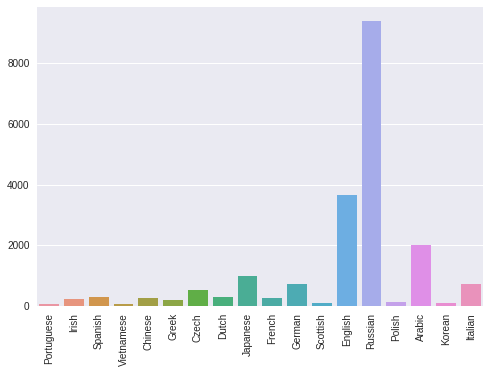

In [0]:
#plot the distribution
plt.style.use("seaborn")
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation = 90)
plt.show()

# RNN Network

In [0]:
#define a basic rnn network

class RNN_net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        #declare the hidden size for the network
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #input to hidden layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #input to output layer
        self.softmax = nn.LogSoftmax(dim = 1) #softmax for classification
    
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1) #concatenate tensors on column wise
        hidden = self.i2h(combined) #generate hidden representation
        output = self.i2o(combined) #generate output representation
        output = self.softmax(output) #get the softmax label
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
#declare the size of the hidden layer representation
n_hidden = 128

#create a object of the class
net = RNN_net(n_letters, n_hidden, n_languages)

In [0]:
#function to make inference

def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [0]:
#before training the network, make a inference to test the network

output = infer(net, "Adam")
index = torch.argmax(output)
print(output, index)

tensor([[-2.8833, -2.9890, -2.9155, -2.8551, -2.9339, -2.9087, -2.7798, -2.8491,
         -2.8261, -2.7706, -2.9423, -2.9466, -2.9898, -2.8091, -2.8647, -3.0544,
         -2.8575, -2.8995]], grad_fn=<LogSoftmaxBackward>) tensor(9)


# Evaluate Basic RNN Model
- Create a evaluation setup

In [0]:
#create a dataloader

def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret


In [0]:
dataloader(1, X_train, y_train)

[('Winter',
  'German',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [0]:
#create a function to evaluate model

def eval(net, n_points, k, X_, y_):
     data_ = dataloader(n_points, X_, y_)
     correct = 0

     for name, language, name_ohe, lang_rep in data_:
         output = infer(net, name) #prediction
         val, indices = output.topk(k) #get the top k predictions

         if lang_rep in indices:
             correct += 1
    
     accuracy = correct/n_points
     return accuracy

In [0]:
#basic model evaluation - top 3 accuracy

eval(net, 100, 3, X_test, y_test)

0.43

# Training SetUp

In [0]:
#function to train the data

def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5):

    criterion = nn.NLLLoss() #define a loss function
    opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum) #define a optimizer
    loss_arr = np.zeros(n_batches + 1)

    #iterate through all the batches
    for i in range(n_batches):
        loss_arr[i + 1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)

        if i%display_freq == display_freq - 1:
            clear_output(wait = True)

            print("Iteration number ", i + 1, "Top - 1 Accuracy:", round(eval(net, len(X_test), 1, X_test, y_test),4), 
                  'Top-2 Accuracy:', round(eval(net, len(X_test), 2, X_test, y_test),4), 'Loss:', round(loss_arr[i],4))
            plt.figure()
            plt.plot(loss_arr[1:i], "-*")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
            print("\n\n")


Iteration number  100 Top - 1 Accuracy: 0.6838 Top-2 Accuracy: 0.7947 Loss: 2.0 4


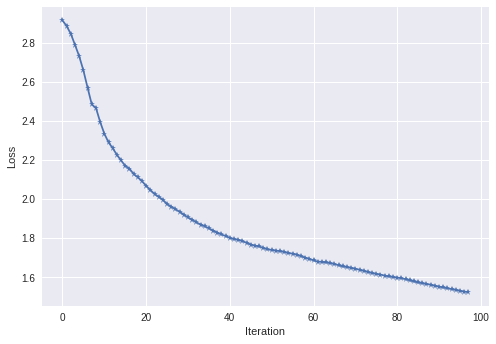

In [0]:
#declare all the parameters

n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 256)

# LSTM Implementation

In [0]:
#LSTM class

class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size) #LSTM cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

Iteration number  100 Top - 1 Accuracy: 0.5357 Top-2 Accuracy: 0.6933 Loss: 2.0 4


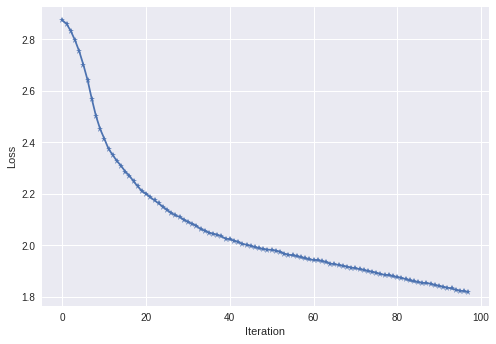

In [0]:
#create hyperparameters
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 256)

# GRU Unit

In [0]:
#GRU implementation

class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size) #gru cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

Iteration number  100 Top - 1 Accuracy: 0.5624 Top-2 Accuracy: 0.6848 Loss: 2.0 4


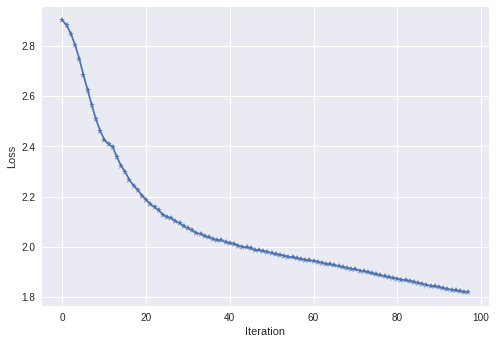

In [0]:
#hyperparameters

n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 256)

# Exercises

- Compute language wise accuracy, plot confusion matrix
- Play with hyper-parameters and try to get better results
- Observe gradient explosion at higher learning rates
- Increase performance by moving to GPU
- Think about how to increase performance further (idea: are we benefiting from batching in our implementation?)